# Basic Model Testing

In [2]:
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import sys

In [3]:
mod1 = torch.load(sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth')

In [4]:
for name in mod1['state_dict']:
    print(name)

module.conv1.weight
module.bn1.weight
module.bn1.bias
module.bn1.running_mean
module.bn1.running_var
module.bn1.num_batches_tracked
module.layer1.0.conv1.weight
module.layer1.0.bn1.weight
module.layer1.0.bn1.bias
module.layer1.0.bn1.running_mean
module.layer1.0.bn1.running_var
module.layer1.0.bn1.num_batches_tracked
module.layer1.0.conv2.weight
module.layer1.0.bn2.weight
module.layer1.0.bn2.bias
module.layer1.0.bn2.running_mean
module.layer1.0.bn2.running_var
module.layer1.0.bn2.num_batches_tracked
module.layer1.1.conv1.weight
module.layer1.1.bn1.weight
module.layer1.1.bn1.bias
module.layer1.1.bn1.running_mean
module.layer1.1.bn1.running_var
module.layer1.1.bn1.num_batches_tracked
module.layer1.1.conv2.weight
module.layer1.1.bn2.weight
module.layer1.1.bn2.bias
module.layer1.1.bn2.running_mean
module.layer1.1.bn2.running_var
module.layer1.1.bn2.num_batches_tracked
module.layer2.0.conv1.weight
module.layer2.0.bn1.weight
module.layer2.0.bn1.bias
module.layer2.0.bn1.running_mean
module.lay

# Loading the Dataset

In [5]:
import os
import sys
sys.path.append(sys.path[0]+'/../lib') # Add library folder
#print(sys.path)

In [6]:
from opts import opts
from datasets.dataset_factory import get_dataset
from datasets.dataset.coco import COCO
from datasets.sample.ctdet import CTDetDataset
from trains.ctdet import CtdetTrainer
from trains.train_factory import train_factory

In [7]:
Dataset = get_dataset('coco', 'ctdet')

# Initializing opt

In [8]:
sys.path.append(sys.path[0]+'/../project_tools')
from fcn_opts import fcn_opts
opt = fcn_opts(Dataset)

Create opt for passing to the constructor. \
Also pass a string with the training value

## Loading Full Dataset

In [9]:
dataset = Dataset(opt,'train')
valset = Dataset(opt, 'val')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=13.70s)
creating index...
index created!
Loaded train 118287 samples
==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
Loaded val 5000 samples


## Modifying dataset

For initial testing we are modifying the dataset to a smaller size. The following code updates the json file list to use a smalller subset of the data. 

In [10]:
all_Ids=dataset.coco.getImgIds()
print(len(all_Ids))
import skimage.io as io
img_dir='~/MoDL_CenterNet/data/coco/train2017/'

118287


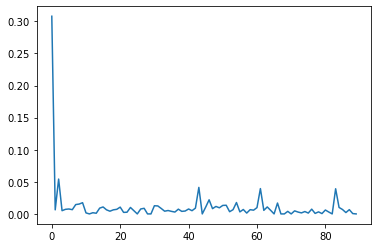

In [11]:
N=512
import random
np.random.seed(0)
numsets=1
for iter in range(numsets):
    imgIds_perm=np.random.permutation(len(all_Ids))
    tmp=imgIds_perm[0:N].astype(int)
    tmp2=[all_Ids[t] for t in tmp]
    dataset.images=tmp2
    dataset.num_samples=len(dataset.images)
    sub_inst_cat=np.zeros(90)
    for j in range(N):
        sub_cat_lab=[]
        img = dataset.coco.loadImgs(dataset.images[j])[0]
        f_name=img_dir
        f_name+=img['file_name']
        annIds = dataset.coco.getAnnIds(imgIds=img['id'])
        anns = dataset.coco.loadAnns(annIds)
        sub_cat_lab=[k['category_id'] for k in anns]
        for jj in range(90):
            t=np.where(np.asarray(sub_cat_lab)==jj)
            sub_inst_cat[jj-1]+=t[0].shape[0]
    prob_sub=(sub_inst_cat+1)/np.sum(sub_inst_cat+1)    
    plt.plot(sub_inst_cat/(np.sum(sub_inst_cat)))
np.random.seed(2)

In [12]:
opt.num_iters = dataset.num_samples/opt.batch_size
#print(dataset.images)

## Dataloader

In [13]:
train_loader = td.DataLoader(
      dataset, 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

In [14]:
val_loader = torch.utils.data.DataLoader(
      valset, 
      batch_size=1, 
      shuffle=False,
      num_workers=1,
      pin_memory=True
  )

# Model

In [14]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from models.model import create_model, load_model, save_model
from trains.ctdet import CtdetTrainer

In [17]:
# regression on center point.
opt.arch = 'resdcn_18'
model = create_model(opt.arch, opt.heads, opt.head_conv)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution


In [18]:
optimizer = torch.optim.Adam(model.parameters(), opt.lr)

# Trainer

In [19]:
trainer = CtdetTrainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

# Running main training loop

In [20]:
## Test for Using their train function from Ctdetrainer
# print('Starting training...')
# best = 1e10
# for epoch in range(start_epoch + 1, opt.num_epochs + 1):
#     log_dict_train, _ = trainer.train(epoch, train_loader)
    

In [15]:
sys.path.append(sys.path[0]+"/../project_tools")
import nntools as nt

In [22]:
for name,param in model.named_parameters():
    if name[0:2]=='hm' or name[0:2]=='re' or name[0:2]=='wh':
        print(param.size())
        print(torch.randn(param.size()))
    else:
        param.requires_grad=False

torch.Size([64, 64, 3, 3])
tensor([[[[ 6.1445e-01, -1.5620e+00,  8.7126e-01],
          [ 6.4348e-01,  8.1108e-01,  2.2428e+00],
          [ 1.1099e+00,  2.7187e-01,  1.2092e+00]],

         [[-9.2622e-01, -5.5268e-01,  5.2086e-01],
          [-6.5063e-01,  8.0540e-01, -8.0129e-01],
          [ 1.6166e+00,  2.2605e+00, -1.6139e+00]],

         [[-1.8660e+00,  2.0022e-01,  4.9693e-01],
          [-1.4064e-01,  7.7603e-01,  2.0588e+00],
          [-8.4105e-01,  1.2378e+00, -1.1317e+00]],

         ...,

         [[-5.9452e-01, -7.2438e-01, -8.5948e-01],
          [-7.9854e-01, -1.6400e-01, -1.6190e+00],
          [-5.2398e-01,  9.4872e-02, -1.3735e+00]],

         [[-1.1921e+00, -5.7336e-01,  4.5761e-01],
          [ 1.9236e-01,  1.0647e+00,  7.4071e-01],
          [-1.3734e+00, -1.2287e+00, -3.0384e-01]],

         [[ 1.4402e+00, -9.6416e-01, -1.7836e+00],
          [ 1.0717e+00,  1.5302e+00,  9.2794e-01],
          [ 7.8576e-01, -4.2400e-01,  6.7624e-01]]],


        [[[ 1.2057e+00, -5

In [23]:
class Centernet_model(nt.NeuralNetwork,CtdetTrainer):
    def __init__(self,opt,model,optimizer=None,FineTune=True):
        nt.NeuralNetwork.__init__(self)
        CtdetTrainer.__init__(self,opt,model,optimizer=None)
        if FineTune:
            for name,param in model.named_parameters():
               if name[0:2]=='hm' or name[0:2]=='re' or name[0:2]=='wh':
                    param = torch.randn(param.size()) # Random initialization
               else: 
                    param.requires_grad=False
            #print(name,param.requires_grad)
        self.model=model
        self.opt=opt
    def forward(self,x):
        return self.model(x)
    def criterion(self, y, d):
        return self.loss(y,d)

In [24]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    #image=np.int(((image-np.min(image))/(np.max(image)-np.min(image)))*255)
    #print(image.shape)
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [25]:
mod1 = torch.load(sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth')

In [26]:
model1 =load_model(model,sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth');
net = Centernet_model(opt,model1);
net = net.to(opt.device)
train_loader = td.DataLoader(
      dataset, 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

loaded /datasets/home/home-01/40/940/rpote/MoDL_CenterNet/src/local_notebooks/../../models/ctdet_coco_resdcn18.pth, epoch 140


## Data Augmentation

0


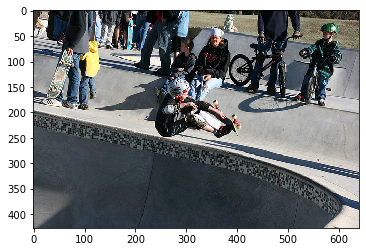

torch.Size([3, 512, 512]) (427, 640, 3)
1


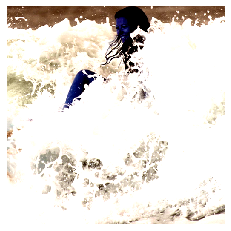

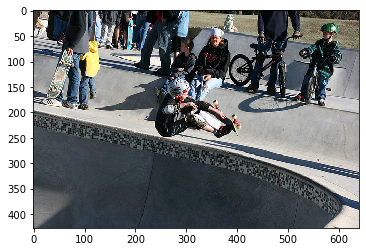

torch.Size([3, 512, 512]) (427, 640, 3)
2


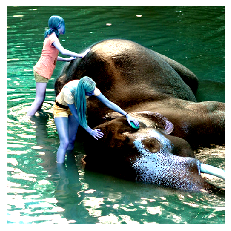

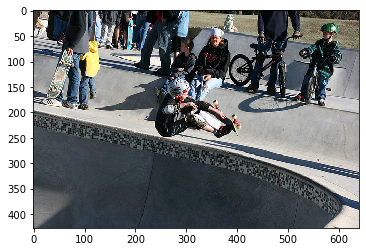

torch.Size([3, 512, 512]) (427, 640, 3)
3


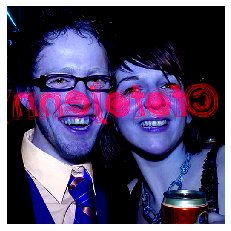

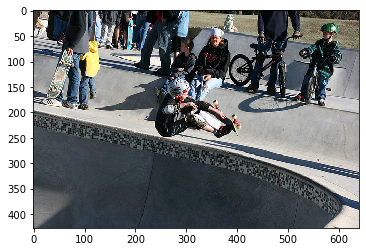

torch.Size([3, 512, 512]) (427, 640, 3)
4


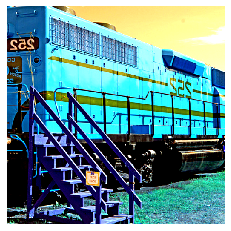

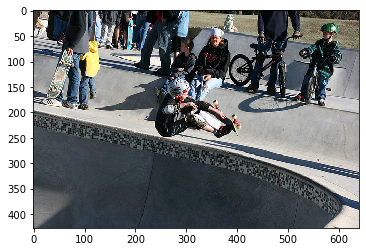

torch.Size([3, 512, 512]) (427, 640, 3)
5


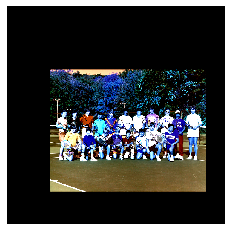

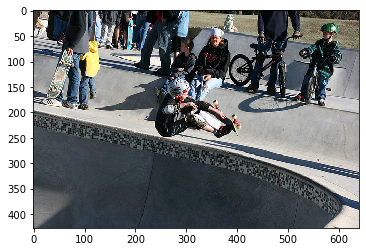

torch.Size([3, 512, 512]) (427, 640, 3)
6


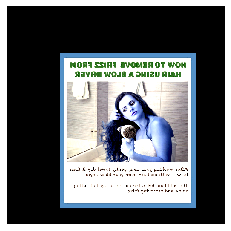

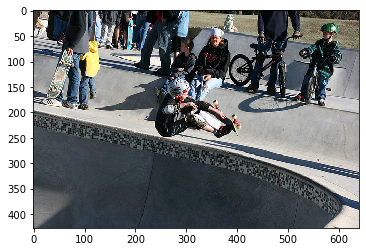

torch.Size([3, 512, 512]) (427, 640, 3)
7


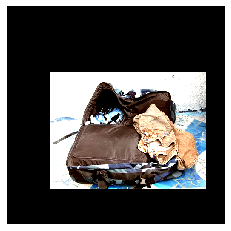

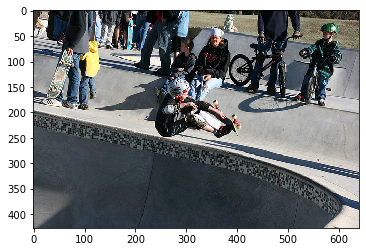

torch.Size([3, 512, 512]) (427, 640, 3)


KeyboardInterrupt: 

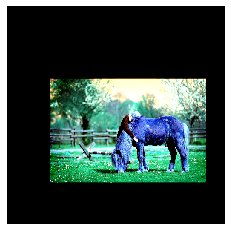

In [32]:
import cv2
import skimage.io as io
for idx,batch in enumerate(train_loader):
    print(idx)
    x1=batch['input']
    img = dataset.coco.loadImgs(dataset.images[0])[0]
    f_name=img_dir
    f_name+=img['file_name']
    I = io.imread(f_name)
    plt.figure()
    plt.imshow(I)
    plt.show()
    #x = np.moveaxis(x, [0, 1, 2], [2, 0, 1])
    #     plt.figure()
    #     plt.imshow(x)
    #     plt.show()
    myimshow(x1[0,:,:,:])
    print(x1[0,:,:,:].shape,I.shape)

In [33]:
torch.equal(x,x1)
print()

NameError: name 'x' is not defined

In [ ]:
import cv2
import skimage.io as io
for idx,batch in enumerate(train_loader):
    x=batch['input']
    img = dataset.coco.loadImgs(dataset.images[0])[0]
    f_name=img_dir
    f_name+=img['file_name']
    I = io.imread(f_name)
    plt.figure()
    plt.imshow(I)
    plt.show()
    #x = np.moveaxis(x, [0, 1, 2], [2, 0, 1])
    #     plt.figure()
    #     plt.imshow(x)
    #     plt.show()
    myimshow(x[0,:,:,:])
    print(x[0,:,:,:].shape,I.shape)

## Manual Batch Loss computation

In [27]:
for idx,batch in enumerate(train_loader):
    #print(idx)
    for k in batch:
        if k != 'meta':
            batch[k] = batch[k].to(device=opt.device, non_blocking=True) 
    y=net.model(batch['input'])
    #y=net.model(batch['input'])
    #batch = batch.to(net.device)
    #y,_,_=net.model_with_loss(batch)
    #print(idx)
    loss1,_ = net.loss(y,batch)

NameError: name 'net' is not defined

In [ ]:
print(loss1.mean())

In [31]:
for name,param in net.model.named_parameters():
    print(name,param.size(),param.requires_grad)

conv1.weight torch.Size([64, 3, 7, 7]) False
bn1.weight torch.Size([64]) False
bn1.bias torch.Size([64]) False
layer1.0.conv1.weight torch.Size([64, 64, 3, 3]) False
layer1.0.bn1.weight torch.Size([64]) False
layer1.0.bn1.bias torch.Size([64]) False
layer1.0.conv2.weight torch.Size([64, 64, 3, 3]) False
layer1.0.bn2.weight torch.Size([64]) False
layer1.0.bn2.bias torch.Size([64]) False
layer1.1.conv1.weight torch.Size([64, 64, 3, 3]) False
layer1.1.bn1.weight torch.Size([64]) False
layer1.1.bn1.bias torch.Size([64]) False
layer1.1.conv2.weight torch.Size([64, 64, 3, 3]) False
layer1.1.bn2.weight torch.Size([64]) False
layer1.1.bn2.bias torch.Size([64]) False
layer2.0.conv1.weight torch.Size([128, 64, 3, 3]) False
layer2.0.bn1.weight torch.Size([128]) False
layer2.0.bn1.bias torch.Size([128]) False
layer2.0.conv2.weight torch.Size([128, 128, 3, 3]) False
layer2.0.bn2.weight torch.Size([128]) False
layer2.0.bn2.bias torch.Size([128]) False
layer2.0.downsample.0.weight torch.Size([128, 64

## Experiment with custom function run2

In [32]:
adam = torch.optim.Adam(net.parameters(), lr=opt.lr)
stats_manager = nt.StatsManager()
exp2 = nt.Experiment(net,dataset,valset,adam,stats_manager,
output_dir="BaseExperiment", batch_size=opt.batch_size,perform_validation_during_training=False)

In [33]:
exp2.run2(num_epochs=5)

Start/Continue training from epoch 0


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1 (Time: 50.99s)
Epoch 2 (Time: 49.48s)
Epoch 3 (Time: 50.11s)
Epoch 4 (Time: 51.26s)
Epoch 5 (Time: 49.50s)
Finish training for 5 epochs


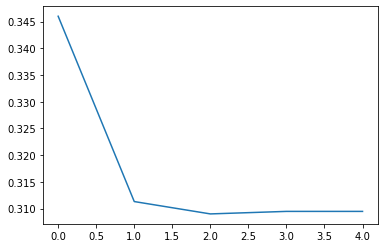

In [34]:
plt.plot(exp2.history)
plt.show()

## Detector

In [16]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from detectors.ctdet import CtdetDetector

In [17]:
opt.load_model = '/datasets/home/home-01/40/940/rpote/MoDL_CenterNet/models/ctdet_coco_resdcn18.pth'
opt.dataset = 'coco'
opt.debugger_theme = 'white'
opt.flip_test = True
opt.K = 3
opt.nms = True
opt.vis_thresh = 0.3

In [18]:
detector = CtdetDetector(opt)
#detector.model = exp_whwt.net.model

Creating model...
=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
loaded /datasets/home/home-01/40/940/rpote/MoDL_CenterNet/models/ctdet_coco_resdcn18.pth, epoch 140


In [28]:
tst_id = 87
img_id = valset.images[tst_id]
img_info = valset.coco.loadImgs(ids=[img_id])[0]
img_path = os.path.join(valset.img_dir, img_info['file_name'])
ret = detector.run(img_path)

In [29]:
print([(ret['results'][i+1].shape[0],i+1) for i in range(80)])

[(1, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (1, 52), (0, 53), (0, 54), (0, 55), (1, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80)]


{'license': 4, 'file_name': '000000321214.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000321214.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-20 22:11:08', 'flickr_url': 'http://farm9.staticflickr.com/8030/8037209348_6491cf571e_z.jpg', 'id': 321214}


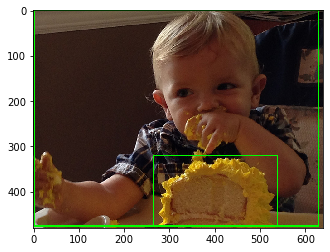

In [30]:
#for kk in valset[0]:
#    print(kk)
import cv2
im_id = valset[tst_id]['meta']['img_id']
img = valset.coco.loadImgs(im_id)[0]
print(img)
img_dir='~/MoDL_CenterNet/data/coco/val2017/'
f_name=img_dir
f_name+=img['file_name']
import skimage.io as io
I = io.imread(f_name)
for c_id in range(80):
    for j in range(ret['results'][c_id+1].shape[0]):
        if ret['results'][c_id+1][j][4]>=0.3:
            cv2.rectangle(I, (ret['results'][c_id+1][j][0], ret['results'][c_id+1][j][1]),(ret['results'][c_id+1][j][2], ret['results'][c_id+1][j][3]), (0,255,0), 2)
plt.imshow(I)
#im=np.moveaxis(im,[0,1,2],[2,0,1])
#im = im.reshape(512,512,3)
#cv2
#print(im.shape)